In [4]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.cm
import matplotlib
from PIL import Image
import numpy as np
from dataclasses import dataclass
from scipy.stats import norm, qmc
from IPython.display import clear_output
from mandelbrot import MandelbrotSet

%matplotlib inline

np.warnings.filterwarnings("ignore")

## Creating an image of the Mandelbrotset

In [2]:
top = matplotlib.cm.get_cmap('Blues_r', 256)
bottom = matplotlib.cm.get_cmap('binary', 256)
newcolors = np.vstack((top(np.linspace(0, 1, 256)), bottom(np.linspace(0, 1, 256))))
newcmp = matplotlib.colors.ListedColormap(newcolors, name='BlGy')

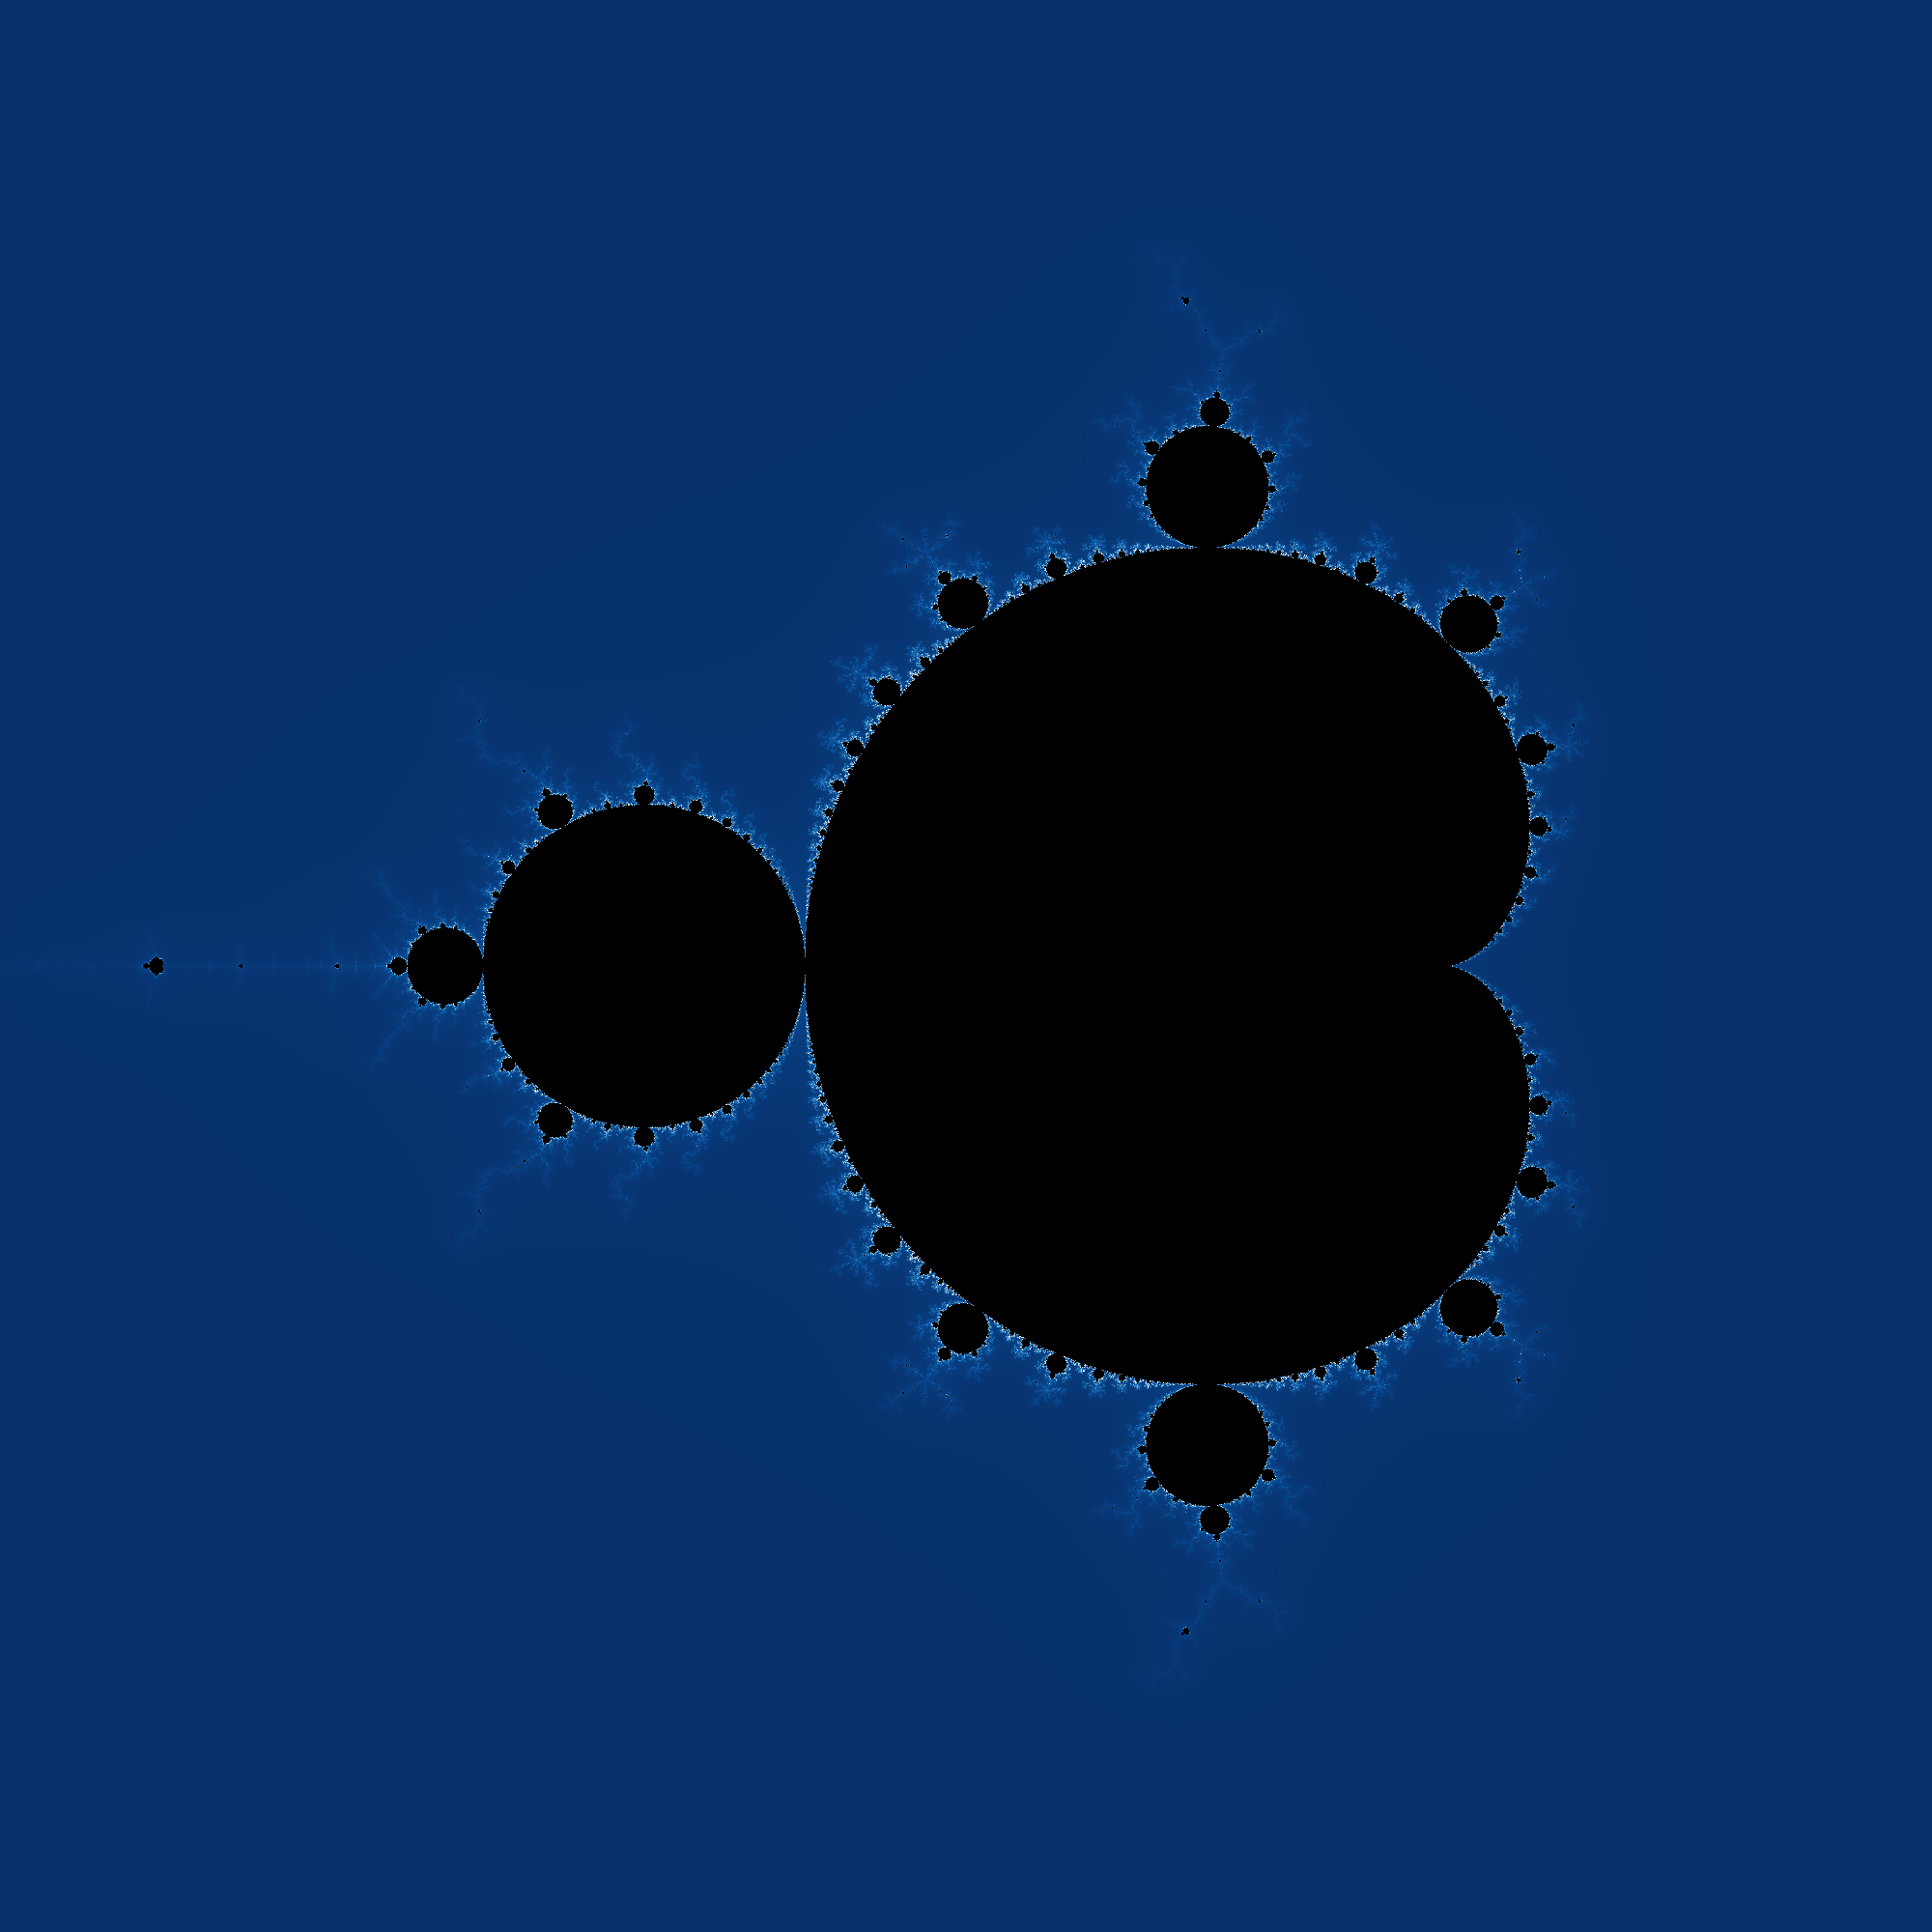

In [3]:
mandelbrotset = MandelbrotSet(1000, 10000, (-2, 1), (-1.5, 1.5))
display(mandelbrotset.create_image(2000, 2000, cmap=newcmp))

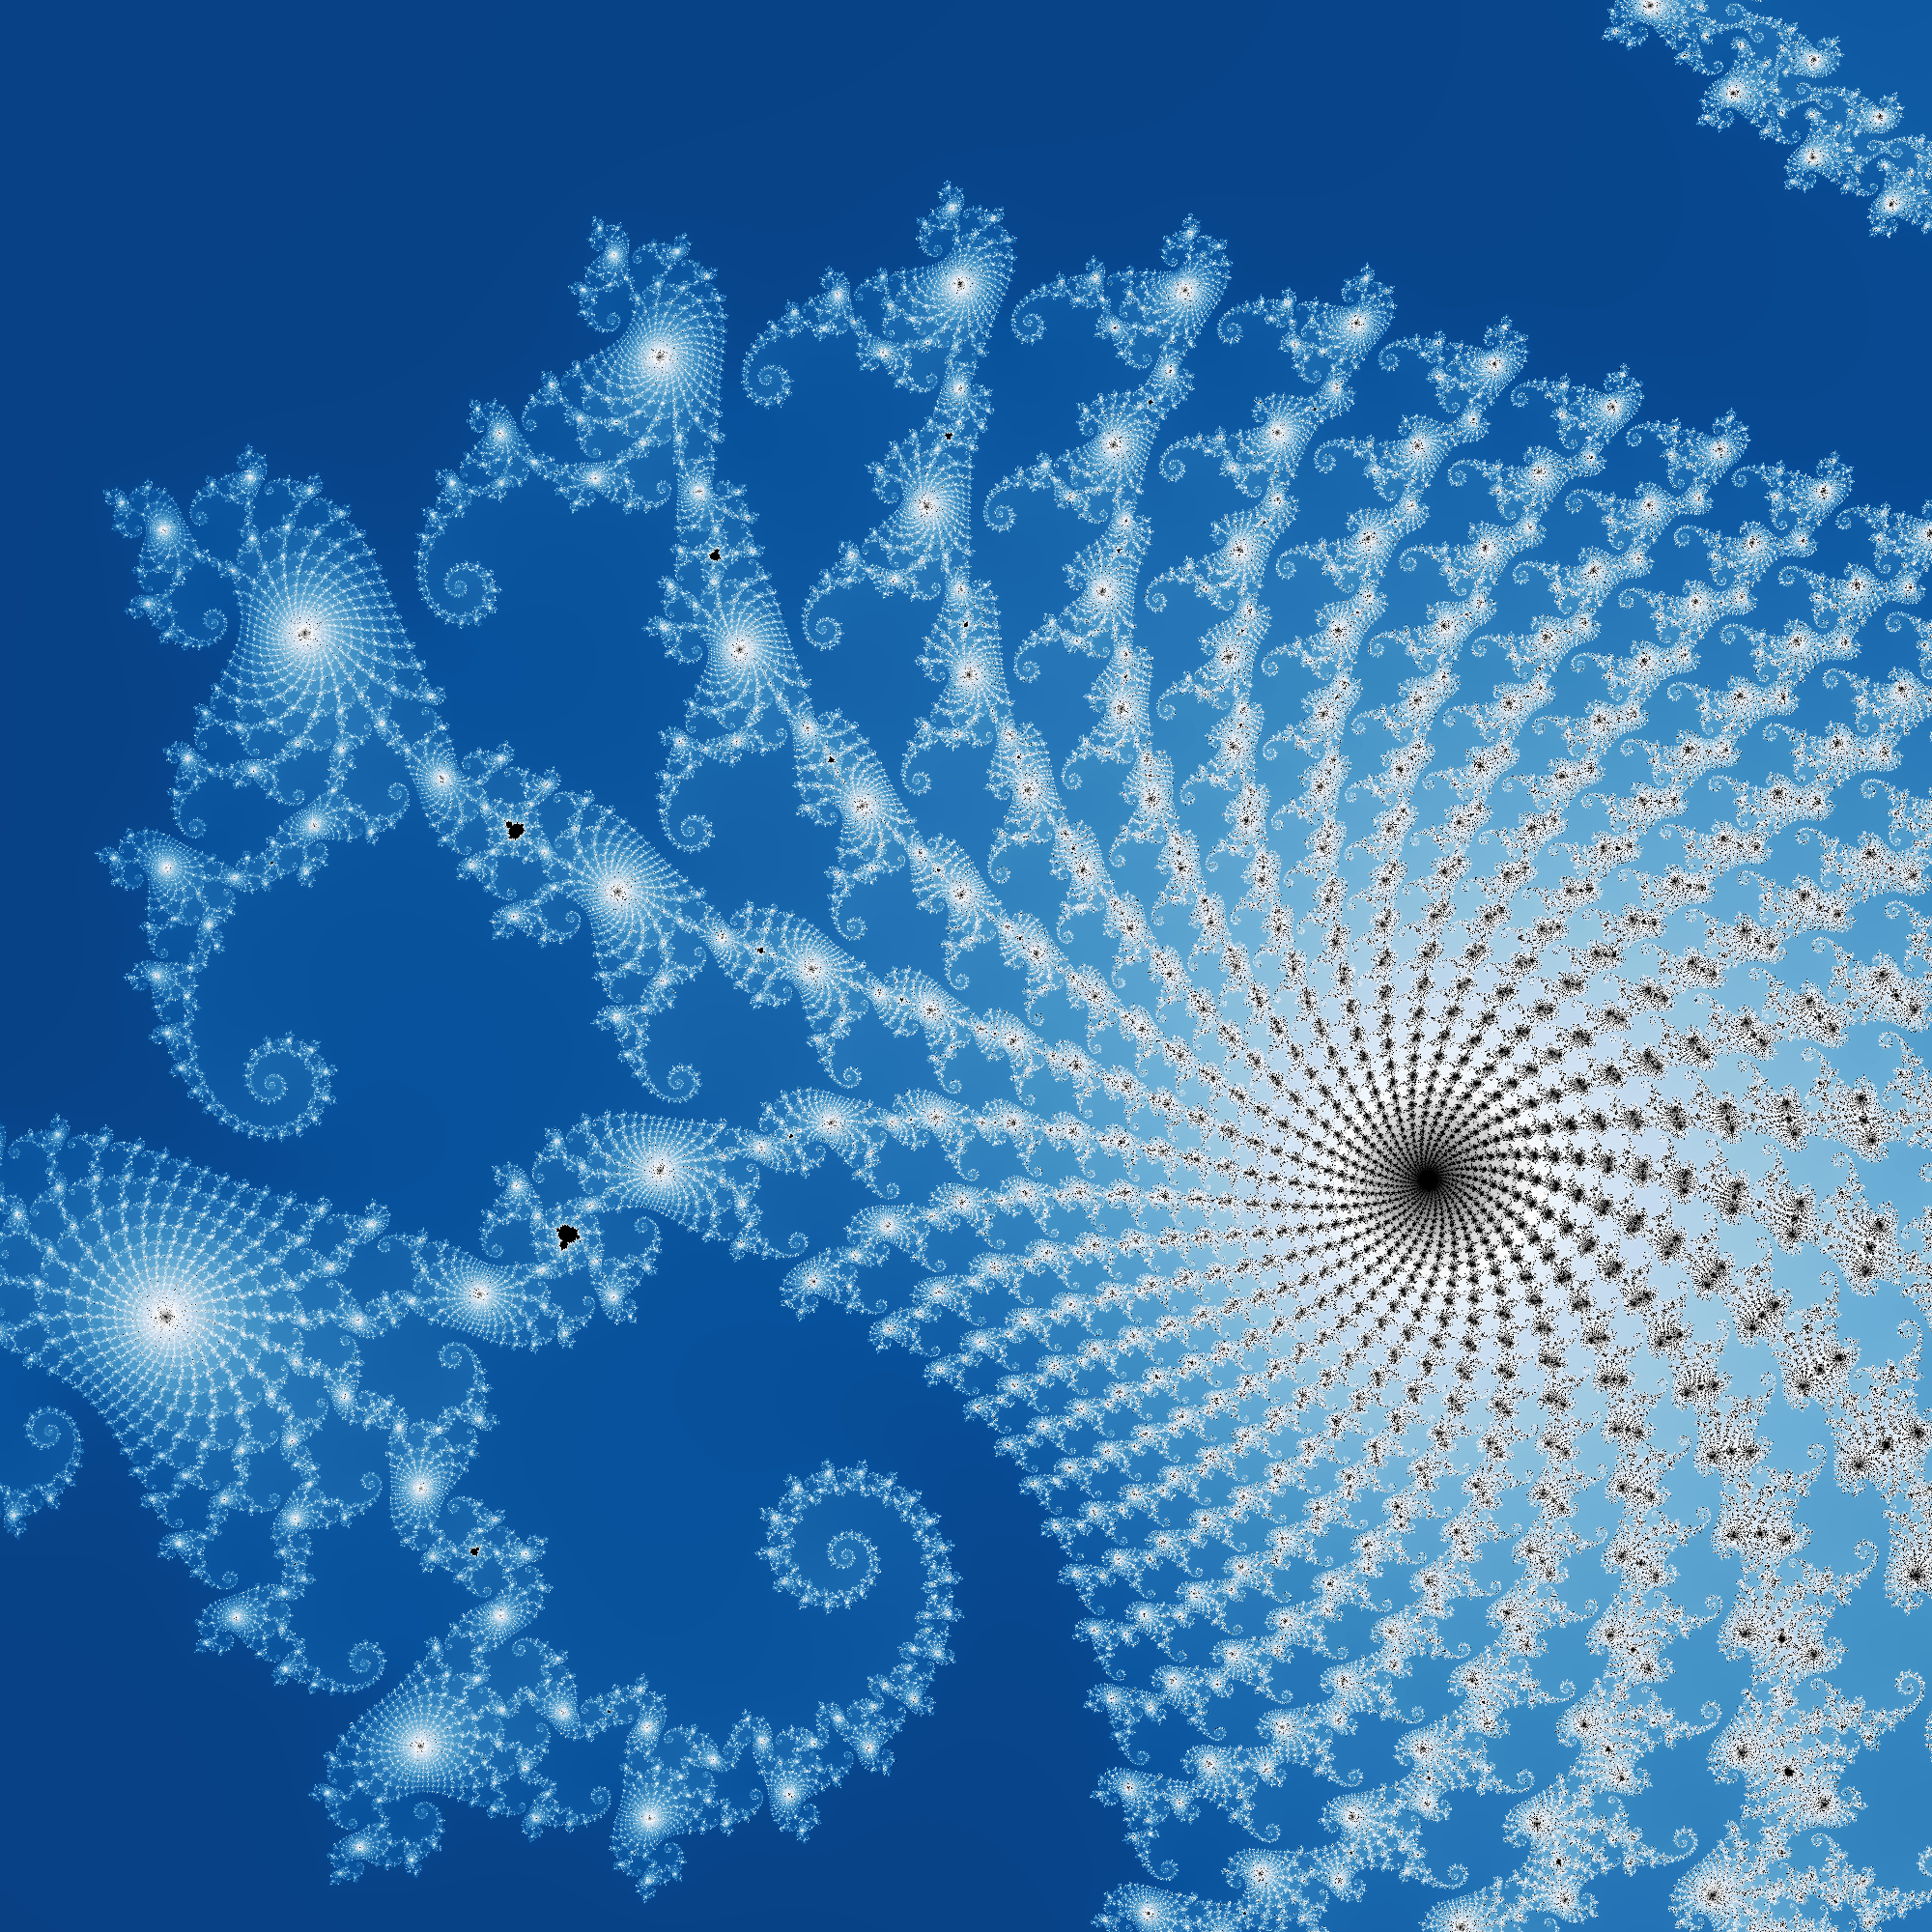

In [4]:
X = -0.748
Y = 0.1
R = 0.0014

mandelbrotset = MandelbrotSet(1000, 10000, (X-R, X+R), (Y-R, Y+R))
display(mandelbrotset.create_image(2000, 2000, cmap=newcmp))

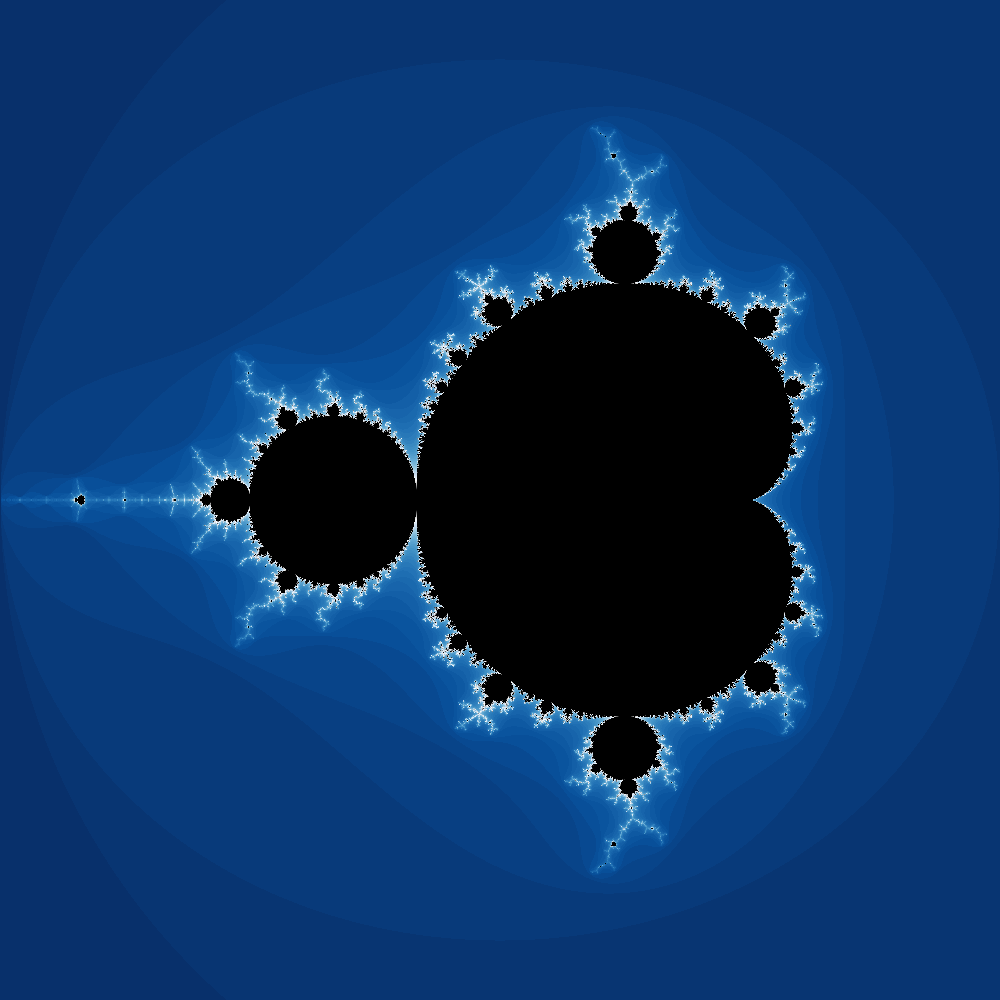

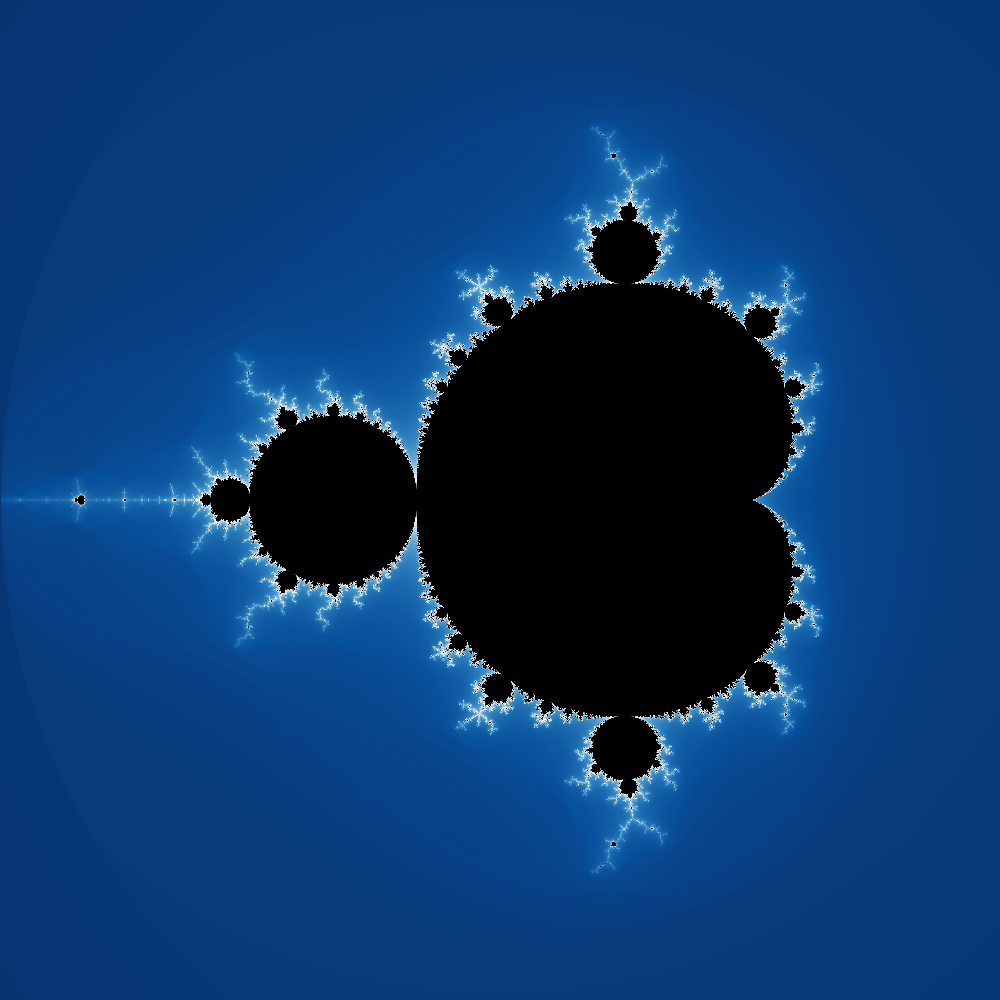

In [5]:
top = matplotlib.cm.get_cmap('Blues_r', 256)
bottom = matplotlib.cm.get_cmap('binary', 256)
newcolors = np.vstack((top(np.linspace(0, 1, 256)), bottom(np.linspace(0, 1, 256))))
newcmp = matplotlib.colors.ListedColormap(newcolors, name='BlGy')

mandelbrotset = MandelbrotSet(100, 10000, (-2, 1), (-1.5, 1.5))
display(mandelbrotset.create_image(1000, 1000, cmap=newcmp, banding=True))
display(mandelbrotset.create_image(1000, 1000, cmap=newcmp, banding=False))

## Convergence of $A_{i,s} \rightarrow A_M$

In [3]:
def area_estimate_i_convergence(i_max, step, s, n_simulations, sampling_method, re_bounds=(-2, 1), im_bounds=(-1.5, 1.5)):
    i_list = range(1, i_max + step, step)

    estimates = np.zeros((n_simulations, len(i_list)))

    for n in range(n_simulations):
        for count, i in enumerate(i_list):
            mandelbrotset = MandelbrotSet(i, s, re_bounds, im_bounds)
            estimates[n, count] = mandelbrotset.area_estimate(sampling_method)
            
        clear_output(wait=True)
        print(f'Simulation {n} complete')
        
    return i_list, estimates

def area_estimate_s_convergence(s_max, step, i, n_simulations, sampling_method, re_bounds=(-2, 1), im_bounds=(-1.5, 1.5), s_list=None):
    if s_list == None:
        s_list = range(step, s_max + step, step)

    estimates = np.zeros((n_simulations, len(s_list)))

    for n in range(n_simulations):
        for count, s in enumerate(s_list):
            mandelbrotset = MandelbrotSet(i, s, re_bounds, im_bounds)
            estimates[n, count] = mandelbrotset.area_estimate(sampling_method)

        clear_output(wait=True)
        print(f'Simulation {n} complete')

    return s_list, estimates

def get_confidence_interval(p, estimates):
    phi = 0.5*(p+1)
    lamda = norm.ppf(phi)

    S_sq = 0
    X_bar = np.mean(estimates, axis=0)
    j_max = np.shape(estimates)[0]

    for j in range(j_max):
        X_j = estimates[j, :]
        
        S_sq += ((X_j - X_bar)**2) / (j_max - 1)

    a = lamda * np.sqrt(S_sq) / np.sqrt(j_max)
    return a

In [4]:
def plot_i_convergence(i_list, i_estimates, a_i, **kwargs):
    # Keyword arguments
    figsize = kwargs.pop('figsize', (6, 4.5))
    title = kwargs.pop('title', r'Area estimate convergence for $i$')
    ms = kwargs.pop('ms', 4)
    lw = kwargs.pop('lw', 1)
    alpha = kwargs.pop('alpha', 0.4)
    a_i_label = kwargs.pop('a_i_label', '95% confidence interval')
    xlim = kwargs.pop('xlim', (None, None))
    ylim = kwargs.pop('ylim', (None, None))
    
    zoom = kwargs.pop('zoom', 10)
    xlim_zoom = kwargs.pop('xlim_zoom', (100, 110))
    ylim_zoom = kwargs.pop('xlim_zoom', (1.45, 1.6))
    ms_zoom = kwargs.pop('ms_zoom', 3)
    lw_zoom = kwargs.pop('lw_zoom', 1)

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    mean = np.mean(i_estimates, axis=0)

    ax.plot(i_list, mean, 'o-', ms=ms, lw=lw)
    ax.fill_between(i_list, mean-a_i, mean+a_i, alpha=alpha, label=a_i_label)
    ax.set(xbound=xlim, ybound=ylim, xlabel='Iterations', ylabel='Area Estimate', title=title)
    ax.grid(axis='y')
    ax.legend(loc='lower right')

    axins = zoomed_inset_axes(ax, zoom, loc=1)
    axins.plot(i_list, mean, 'o-', ms=ms_zoom, linewidth=lw_zoom)
    axins.fill_between(i_list, mean-a_i, mean+a_i, alpha=alpha)
    axins.set(xbound=xlim_zoom, ybound=ylim_zoom)
    axins.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.show()

def plot_s_convergence(s_list, s_estimates, a_s, **kwargs):
    # Keyword arguments
    figsize = kwargs.pop('figsize', (6, 4.5))
    title = kwargs.pop('title', r'Area estimate convergence for $s$')
    ms = kwargs.pop('ms', 4)
    lw = kwargs.pop('lw', 1)
    alpha = kwargs.pop('alpha', 0.4)
    a_s_label = kwargs.pop('a_s_label', '95% confidence interval')
    xlim = kwargs.pop('xlim', (None, None))
    ylim = kwargs.pop('ylim', (None, None))

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    mean = np.mean(s_estimates, axis=0)

    ax.plot(s_list, mean, 'o-', ms=ms, lw=lw)
    ax.fill_between(s_list, mean-a_s, mean+a_s, alpha=alpha, label=a_s_label)
    ax.set(xbound=xlim, ybound=ylim, xlabel='Number of points', ylabel='Area Estimate', title=title)
    ax.grid(axis='y')
    ax.legend(loc='upper right')

    plt.show()

### Pure Random Sampling

#### Convergence as $i \rightarrow \infty$

In [56]:
i_max = 200
s_max = 16000
i_step = 5
n_simulations = 10

i_list_pure_random, i_estimates_pure_random = area_estimate_i_convergence(i_max, i_step, s_max, n_simulations, 'pure_random')
a_i_pure_random = get_confidence_interval(0.95, i_estimates_pure_random)

Simulation 9 complete


In [58]:
np.savez("Pure_random_i_estimates", i_list_pure_random, i_estimates_pure_random)

In [5]:
npzfile = np.load("Pure_random_i_estimates.npz")
i_list_pure_random = npzfile['arr_0']
i_estimates_pure_random = npzfile['arr_1']
a_i_pure_random = get_confidence_interval(0.95, i_estimates_pure_random)

#### Convergence as $s \rightarrow \infty$

In [ ]:
s_max = 15000
i_max = 200
s_step = 250

s_list_pure_random, s_estimates_pure_random = area_estimate_s_convergence(s_max, s_step, i_max, n_simulations, 'pure_random')
a_s_pure_random = get_confidence_interval(0.95, s_estimates_pure_random)

In [61]:
np.savez("Pure_random_s_estimates", s_list_pure_random, s_estimates_pure_random)

In [6]:
npzfile = np.load("Pure_random_s_estimates.npz")
s_list_pure_random = npzfile['arr_0']
s_estimates_pure_random = npzfile['arr_1']
a_s_pure_random = get_confidence_interval(0.95, s_estimates_pure_random)

#### Plots

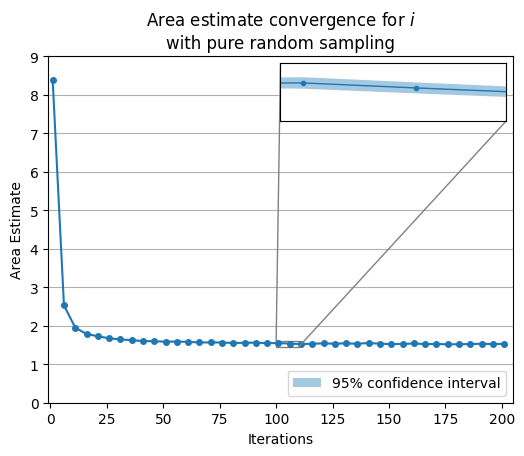

In [7]:
params = {
    'xlim': (-1, 205),
    'ylim': (0, 9),
    'title': r'Area estimate convergence for $i$'+'\nwith pure random sampling',
    'lw': 1.5
}

plot_i_convergence(i_list_pure_random, i_estimates_pure_random, a_i_pure_random, **params)

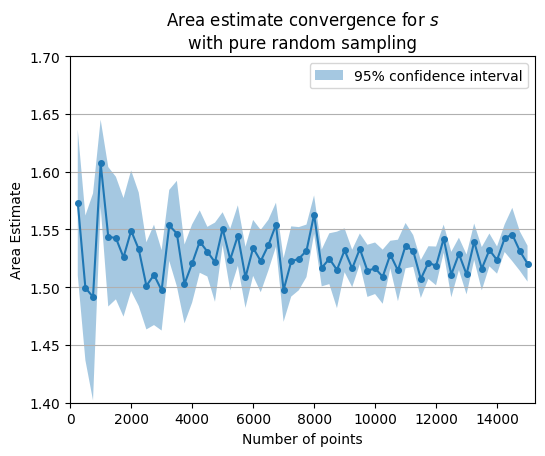

In [8]:
params = {
    'xlim': (0, 15250),
    'ylim': (1.4, 1.7),
    'title': r'Area estimate convergence for $s$'+'\nwith pure random sampling',
    'lw': 1.5
}

plot_s_convergence(s_list_pure_random, s_estimates_pure_random, a_s_pure_random, **params)

#### Final Area estimate

In [17]:
i = 1000
s = 30000
n_simulations = 40

estimates = np.zeros(n_simulations)

for n in range(n_simulations):
    mandelbrotset = MandelbrotSet(i, s, (-2, 1), (-1.5, 1.5))
    estimates[n] = mandelbrotset.area_estimate('pure_random')

    clear_output(wait=True)
    print(f'Simulation {n} complete')

a = get_confidence_interval(0.95, estimates[:, np.newaxis])
print(f'Area estimate for pure random sampling: {round(np.mean(estimates), 5)} +- {round(a[0], 7)}')

Simulation 39 complete
Area estimate for pure random sampling: 1.5051 +- 0.0070337


### Latin Hypercube Sampling

#### Convergence as $i \rightarrow \infty$

In [ ]:
i_max = 200
i_step = 5
s = 16000
n_simulations = 10

i_list_latin_hypercube, i_estimates_latin_hypercube = area_estimate_i_convergence(i_max, i_step, s, n_simulations, 'latin_hypercube')
a_i_latin_hypercube = get_confidence_interval(0.95, i_estimates_latin_hypercube)

In [63]:
np.savez("Latin_hypercube_i_estimates", i_list_latin_hypercube, i_estimates_latin_hypercube)

In [38]:
npzfile = np.load("Latin_hypercube_i_estimates.npz")
i_list_latin_hypercube = npzfile['arr_0']
i_estimates_latin_hypercube = npzfile['arr_1']
a_i_latin_hypercube = get_confidence_interval(0.95, i_estimates_latin_hypercube)

#### Convergence as $s \rightarrow \infty$

In [45]:
s_max = 15000
s_step = 250
i = 200
n_simulations = 10

s_list_latin_hypercube, s_estimates_latin_hypercube = area_estimate_s_convergence(s_max, s_step, i, n_simulations, 'latin_hypercube')
a_s_latin_hypercube = get_confidence_interval(0.95, s_estimates_latin_hypercube)

Simulation 9 complete


In [51]:
np.savez("Latin_hypercube_s_estimates", s_list_latin_hypercube, s_estimates_latin_hypercube)

In [39]:
npzfile = np.load("Latin_hypercube_s_estimates.npz")
s_list_latin_hypercube = npzfile['arr_0']
s_estimates_latin_hypercube = npzfile['arr_1']
a_s_latin_hypercube = get_confidence_interval(0.95, s_estimates_latin_hypercube)

#### Plots

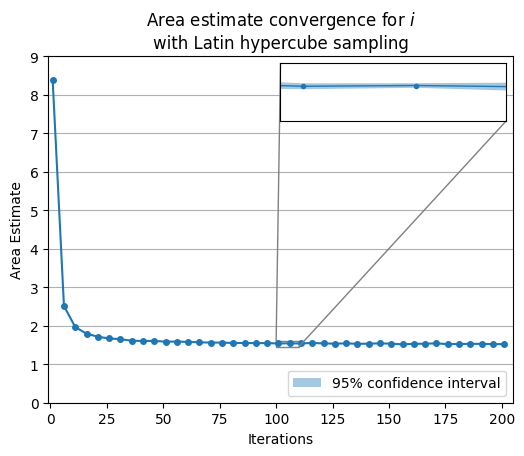

In [40]:
params = {
    'xlim': (-1, 205),
    'ylim': (0, 9),
    'title': r'Area estimate convergence for $i$'+'\nwith Latin hypercube sampling',
    'lw': 1.5
}

plot_i_convergence(i_list_latin_hypercube, i_estimates_latin_hypercube, a_i_latin_hypercube, **params)

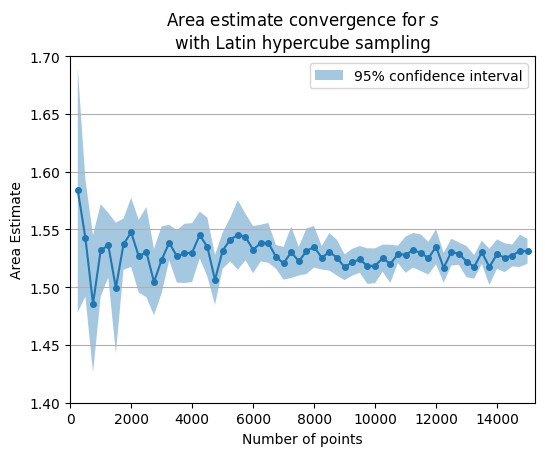

In [41]:
params = {
    'xlim': (0, 15250),
    'ylim': (1.4, 1.7),
    'title': r'Area estimate convergence for $s$'+'\nwith Latin hypercube sampling',
    'lw': 1.5
}

plot_s_convergence(s_list_latin_hypercube, s_estimates_latin_hypercube, a_s_latin_hypercube, **params)

#### Final Area estimate

In [21]:
i = 1000
s = 30000
n_simulations = 40

estimates = np.zeros(n_simulations)

for n in range(n_simulations):
    mandelbrotset = MandelbrotSet(i, s, (-2, 1), (-1.5, 1.5))
    estimates[n] = mandelbrotset.area_estimate('latin_hypercube')

    clear_output(wait=True)
    print(f'Simulation {n} complete')

a = get_confidence_interval(0.95, estimates[:, np.newaxis])
print(f'Area estimate for Latin hypercube sampling: {round(np.mean(estimates), 4)} +- {round(a[0], 6)}')

Simulation 39 complete
Area estimate for Latin hypercube sampling: 1.5146 +- 0.003882


### Orthogonal Sampling

#### Convergence as $i \rightarrow \infty$

In [90]:
i_max = 200
i_step = 5
s = 5041
n_simulations = 10

i_list_orthogonal, i_estimates_orthogonal = area_estimate_i_convergence(i_max, i_step, s, n_simulations, 'orthogonal')
a_i_orthogonal = get_confidence_interval(0.95, i_estimates_orthogonal)

Simulation 9 complete


In [91]:
np.savez("orthogonal_i_estimates", i_list_orthogonal, i_estimates_orthogonal)

In [42]:
npzfile = np.load("orthogonal_i_estimates.npz")
i_list_orthogonal = npzfile['arr_0']
i_estimates_orthogonal = npzfile['arr_1']
a_i_orthogonal = get_confidence_interval(0.95, i_estimates_orthogonal)

#### Convergence as $s \rightarrow \infty$

In [9]:
def is_prime(n):
    if n< 2:
        return False
        
    for i in range(2,n):
        if n%i == 0:
            return False

    return True

In [142]:
s_list = []
for i in range(17, 97):
    if is_prime(i):
        s_list.append(i**2)     

i = 200
n_simulations = 10

s_list_orthogonal, s_estimates_orthogonal = area_estimate_s_convergence(0, 0, i, n_simulations, 'orthogonal', s_list=s_list)
a_s_orthogonal = get_confidence_interval(0.95, s_estimates_orthogonal)

Simulation 19 complete


In [106]:
np.savez("orthogonal_s_estimates", s_list_orthogonal, s_estimates_orthogonal)

In [43]:
npzfile = np.load("orthogonal_s_estimates.npz")
s_list_orthogonal = npzfile['arr_0']
s_estimates_orthogonal = npzfile['arr_1']
a_s_orthogonal = get_confidence_interval(0.95, s_estimates_orthogonal)

#### Plots

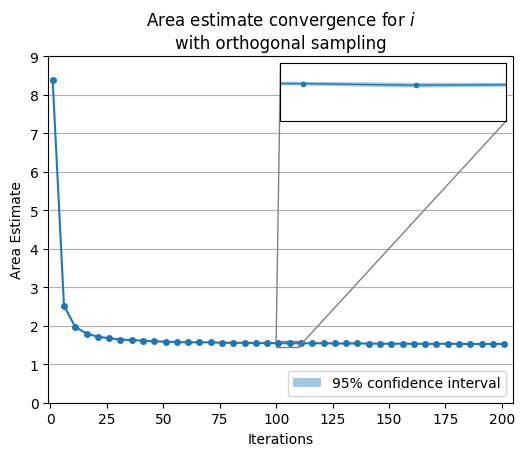

In [44]:
params = {
    'xlim': (-1, 205),
    'ylim': (0, 9),
    'title': r'Area estimate convergence for $i$'+'\nwith orthogonal sampling',
    'lw': 1.5
}

plot_i_convergence(i_list_orthogonal, i_estimates_orthogonal, a_i_orthogonal, **params)

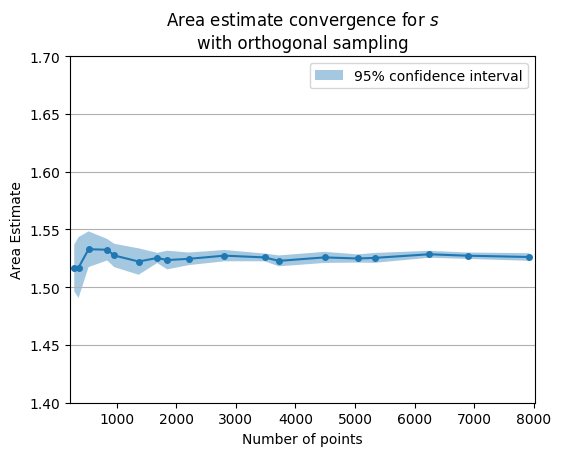

In [146]:
params = {
    'xlim': (220, 8020),
    'ylim': (1.4, 1.7),
    'title': r'Area estimate convergence for $s$'+'\nwith orthogonal sampling',
    'lw': 1.5
}

plot_s_convergence(s_list_orthogonal, s_estimates_orthogonal, a_s_orthogonal, **params)

#### Final Area estimate

In [22]:
i = 1000
s = 10201
n_simulations = 40

estimates = np.zeros(n_simulations)

for n in range(n_simulations):
    mandelbrotset = MandelbrotSet(i, s, (-2, 1), (-1.5, 1.5))
    estimates[n] = mandelbrotset.area_estimate('orthogonal')

    clear_output(wait=True)
    print(f'Simulation {n} complete')

a = get_confidence_interval(0.95, estimates[:, np.newaxis])
print(f'Area estimate for orthogonal sampling: {round(np.mean(estimates), 4)} +- {round(a[0], 6)}')

Simulation 39 complete
Area estimate for orthogonal sampling: 1.5106 +- 0.001185


### Test Sampling

#### Convergence as $i \rightarrow \infty$

In [6]:
i_max = 200
i_step = 5
s = 5041
n_simulations = 5

i_list_test, i_estimates_test = area_estimate_i_convergence(i_max, i_step, s, n_simulations, 'test')
a_i_test = get_confidence_interval(0.95, i_estimates_test)

Simulation 4 complete


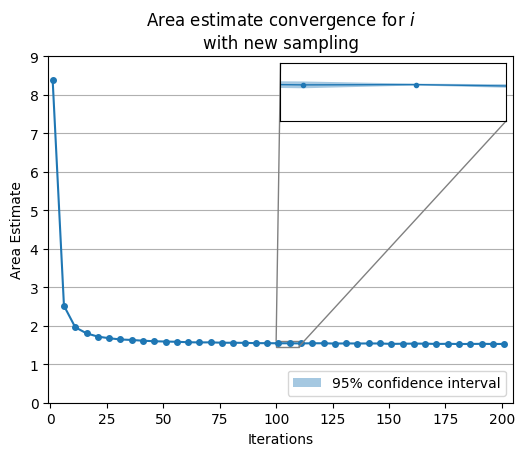

In [7]:
params = {
    'xlim': (-1, 205),
    'ylim': (0, 9),
    'title': r'Area estimate convergence for $i$'+'\nwith new sampling',
    'lw': 1.5
}

plot_i_convergence(i_list_test, i_estimates_test, a_i_test, **params)

#### Convergence as $s \rightarrow \infty$

In [10]:
s_list = []

for i in range(17, 97):
    if is_prime(i):
        s_list.append(i**2)

i = 200
n_simulations = 5

s_list_test, s_estimates_test = area_estimate_s_convergence(0, 0, i, n_simulations, 'test', s_list=s_list)
a_s_test = get_confidence_interval(0.95, s_estimates_test)

Simulation 4 complete


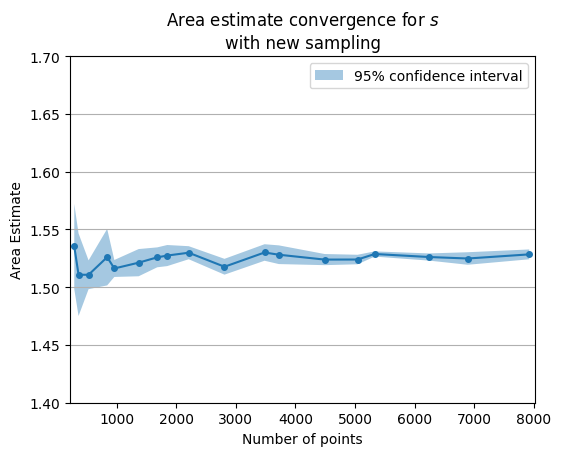

In [11]:
params = {
    'xlim': (220, 8020),
    'ylim': (1.4, 1.7),
    'title': r'Area estimate convergence for $s$'+'\nwith new sampling',
    'lw': 1.5
}

plot_s_convergence(s_list_test, s_estimates_test, a_s_test, **params)

#### Final Area estimate

In [23]:
i = 1000
s = 10201
n_simulations = 20

estimates = np.zeros(n_simulations)

for n in range(n_simulations):
    mandelbrotset = MandelbrotSet(i, s, (-2, 1), (-1.5, 1.5))
    estimates[n] = mandelbrotset.area_estimate('test')

    clear_output(wait=True)
    print(f'Simulation {n} complete')

a = get_confidence_interval(0.95, estimates[:, np.newaxis])
print(f'Area estimate for orthogonal sampling with antithetic variables: {round(np.mean(estimates), 4)} +- {round(a[0], 6)}')

Simulation 19 complete
Area estimate for orthogonal sampling with antithetic variables: 1.5097 +- 0.001491


(1.4975, 1.52)

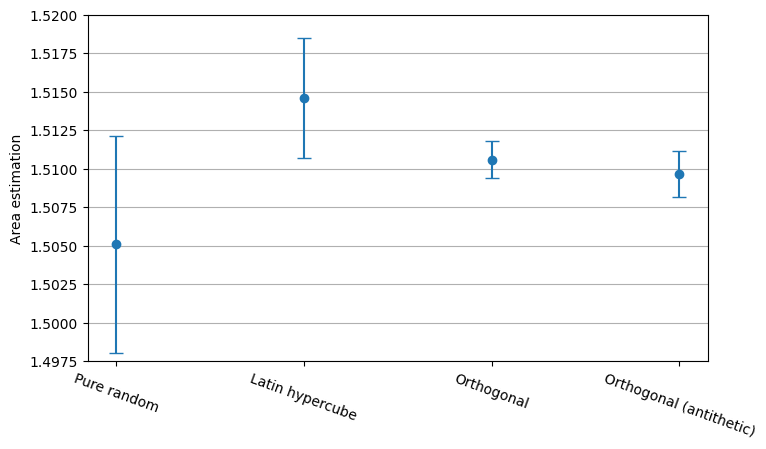

In [43]:
estimates = [1.5051, 1.5146, 1.5106, 1.5097]
intervals = [0.0070337, 0.003882, 0.001185, 0.001491]
labels = ['Pure random', 'Latin hypercube', 'Orthogonal', 'Orthogonal (antithetic)']

plt.figure(figsize=(8, 4.5))
plt.errorbar(range(4), estimates, intervals, fmt='o', capsize=5)
plt.xticks(range(4), labels=labels, rotation = -20)
plt.tick_params()
plt.grid(axis='y')
plt.ylabel('Area estimation')
plt.ylim(1.4975, 1.5200)